# Cross-slope section

Section through gridded data. We use the __[function](https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py)__ `metpy.interpolate.cross_section` to do so. 
 Comparing temp, rho, S in cross-sections around Antarctica

Load modules

In [1]:
# Standard modules
import cosima_cookbook as cc
from cosima_cookbook import explore

from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation 
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm

# Load metpy module to obtain cross section 
# (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

In [2]:
from matplotlib import rc
rc('font', **{'size':25})

In [3]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Start a cluster with multiple cores

In [ ]:
client = Client(local_directory = '/scratch/v45/qo9901/') 
client

Nominate a database from which to load the data and define an experiment

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

exp_ctrl= '01deg_jra55v13_ryf9091_qian_ctrl'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wtlp= '01deg_jra55v13_ryf9091_qian_wtlp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'

In [5]:
depth = 3000

In [6]:
#Pick shelf coordinates
#warm
shelf_coord = (-74, -115+100)
deep_coord  = (-70.5, -115+100)
shelf_coord = (-66.5, -68.5+100)
deep_coord  = (-65, -74+100)
shelf_coord = (-62, -60+100)
deep_coord  = (-56.5, -59+100)
'''
#dense
shelf_coord = (-67, -58+100)
deep_coord  = (-67, -52+100)


# Ribeiro (2021)
shelf_coord = ( -66.75,111 +100)
deep_coord = (-65.75,109 +100)
'''

'\n#dense\nshelf_coord = (-67, -58+100)\ndeep_coord  = (-67, -52+100)\n\n\n# Ribeiro (2021)\nshelf_coord = ( -66.75,111 +100)\ndeep_coord = (-65.75,109 +100)\n'

In [8]:
plot_coord_list = ((-70, 38.5+100,-65, 38.5+100),
                   (-70, 75+100, -65, 75+100),
                   (-71, 23.5+100,-65, 23.5+100),
                   (-80, -55.5+100,-70, -38.5+100),
                   (-80, 173.5+100,-68,  180.5+100),
                   (-68,  143.5+100,-63,  146.5+100),
                   (-73,-96.5+100,-68,  -99.5+100),
                   (-70, -66.5+100,-65, -80.5+100),
                   (-73, -81.5+100,-68, -85.5+100))
plot_coord_list_test = np.array(plot_coord_list)
for l in np.arange(0,len(plot_coord_list)):
    plot_coord_list_test[l,1] = plot_coord_list[l][1]-100
    plot_coord_list_test[l,3] = plot_coord_list[l][3]-100

#select l for coord   
l = 0
shelf_coord = plot_coord_list_test[l][:2]
deep_coord = plot_coord_list_test[l][2:]
shelf_coord = plot_coord_list[l][:2]
deep_coord = plot_coord_list[l][2:]

In [9]:
shelf_coord, deep_coord 

((-70, 138.5), (-65, 138.5))

In [10]:
plot_coord_list_test[l][:2]

array([-70. ,  38.5])

In [79]:
shelf_coord, deep_coord # after

(array([-73. , -81.5]), array([-68. , -85.5]))

In [65]:
shelf_coord, deep_coord # initial

((-73, 18.5), (-68, 14.5))

Load velocity and bathymetry data

In [11]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)
# We will use an annual average from one year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()


In [24]:
ee = explore.ExperimentExplorer(session=session, experiment=exp_ctrl)
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [12]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '05:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/35875/status,
Dashboard: /proxy/35875/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.9:35861,Workers: 0
Dashboard: /proxy/35875/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
salt =cc.querying.getvar(expt=expt, variable='salt', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time, end_time=end_time)

In [14]:
age =cc.querying.getvar(expt=expt, variable='age_global', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time, end_time=end_time)

In [15]:
age

<xarray.DataArray 'age_global' (time: 120, st_ocean: 75, yt_ocean: 2700,
                                xt_ocean: 3600)> Size: 350GB
dask.array<concatenate, shape=(120, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1950-01-16 12:00:00 ... 1959-12-16 12:00:00
Attributes: (12/13)
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

### interplolate for pot_rho_1 and pot_temp
We need a new grid which includes the depth coordinate --> grid_depth

In [16]:
pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session,  start_time=start_time, end_time=end_time, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'}) #ncfile="ocean_daily_3d_pot_rho_1.nc"

pot_temp =cc.querying.getvar(expt=expt, variable='pot_temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, end_time=end_time)


In [17]:
# Load model grid information with depth
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([pot_temp.sel(yt_ocean=lat_slice).sel(st_ocean=slice(0,depth)), grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_depth = xgcm.Grid(ds, periodic=['X'])
grid_depth

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [18]:
ds

<xarray.Dataset> Size: 51GB
Dimensions:     (xt_ocean: 3600, yt_ocean: 483, st_ocean: 60, time: 121,
                 xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean    (st_ocean) float64 480B 0.5413 1.681 ... 2.659e+03 2.834e+03
  * time        (time) object 968B 1900-04-01 00:00:00 ... 1959-12-16 12:00:00
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    geolon_t    (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
Data variables:
    pot_temp    (time, st_ocean, yt_ocean, xt_ocean) float32 50GB dask.array<chunksize=(2, 7, 273, 400), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(483, 900), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(484, 900), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 843MB dask.array<chunksize=(121, 484, 900), meta=np.ndarray>
Attributes: (12/13)
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [19]:
salt

<xarray.DataArray 'salt' (time: 120, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)> Size: 350GB
dask.array<concatenate, shape=(120, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1950-01-16 12:00:00 ... 1959-12-16 12:00:00
Attributes: (12/13)
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [20]:
def rho2_temp_cross_section(expt, shelf_coord, deep_coord,  start_time, end_time):
    step_no = 400
    pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session,  start_time=start_time, end_time=end_time, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'}) #ncfile="ocean_daily_3d_pot_rho_1.nc"
    
    pot_temp =cc.querying.getvar(expt=expt, variable='pot_temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time, end_time=end_time)
    salt =cc.querying.getvar(expt=expt, variable='salt', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time, end_time=end_time)
    
    pot_rho_2 = pot_rho_2.mean(dim = 'time')#.chunk({'st_ocean': 100})
    pot_rho_2 = pot_rho_2.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
    
    pot_temp = pot_temp.mean(dim = 'time')#.chunk({'st_ocean': 100})
    pot_temp = pot_temp.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))

    salt = salt.mean(dim = 'time')#.chunk({'st_ocean': 100})
    salt = salt.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
   
    pot_rho_2 = grid_depth.interp(grid_depth.interp(pot_rho_2, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
    
    # Create dataset
    ds_pot_rho_1= xr.Dataset({"pot_rho_1": pot_rho_2, "lat": pot_rho_2.yu_ocean, "lon": pot_rho_2.xu_ocean})
    # Interpolate to xu_ocean and yu_ocean
    # Rename coordinate names
    ds_pot_rho_1 = ds_pot_rho_1.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    ds_pot_rho_1['x'] = ds_pot_rho_1['x']+100
    
    ds_pot_rho_1['x'].attrs = pot_rho_2['xu_ocean'].attrs
    
    # MetPy parsing
    pot_rho_1_parsed = ds_pot_rho_1.metpy.parse_cf('pot_rho_1', coordinates={'y': 'y', 'x': 'x'})
    pot_rho_1_section = cross_section(pot_rho_1_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')
        
    pot_temp = grid_depth.interp(grid_depth.interp(pot_temp, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
    
    # Create dataset
    ds_pot_temp= xr.Dataset({"pot_temp": pot_temp, "lat": pot_temp.yu_ocean, "lon": pot_temp.xu_ocean})
    # Interpolate to xu_ocean and yu_ocean
    # Rename coordinate names
    ds_pot_temp = ds_pot_temp.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    ds_pot_temp['x'] = ds_pot_temp['x']+100
    
    ds_pot_temp['x'].attrs = pot_temp['xu_ocean'].attrs
    
    # MetPy parsing
    pot_temp_parsed = ds_pot_temp.metpy.parse_cf('pot_temp', coordinates={'y': 'y', 'x': 'x'})
    pot_temp_section = cross_section(pot_temp_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

    salt = grid_depth.interp(grid_depth.interp(salt, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
    
    # Create dataset
    ds_salt= xr.Dataset({"salt": salt, "lat": salt.yu_ocean, "lon": salt.xu_ocean})
    # Interpolate to xu_ocean and yu_ocean
    # Rename coordinate names
    print(ds_salt)
    ds_salt = ds_salt.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    ds_salt['x'] = ds_salt['x']+100
    
    ds_salt['x'].attrs = salt['xu_ocean'].attrs
    
    # MetPy parsing
    salt_parsed = ds_salt.metpy.parse_cf('salt', coordinates={'y': 'y', 'x': 'x'})
    salt_section = cross_section(salt_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

    # Define number of points you want to interpolate
    step_no = 400
    # Radius of the Earth in km
    r = 6371
    # Difference between points in lat/lon space
    dlon = deep_coord[1]-shelf_coord[1]
    dlat = deep_coord[0]-shelf_coord[0]
    # Calculate distance in km between the two end points
    distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0],deep_coord[0]]))))**2))
    # Create array with length of step_no
    distance_in_km = np.linspace(0, distance_endpoints, step_no)
    # Repeat by the number of depth levels
    distance_in_km = np.tile(distance_in_km, (len(pot_temp_section.st_ocean), 1))
        
    return pot_temp_section, pot_rho_1_section, distance_in_km, salt_section.load()

In [21]:
%%time
pot_temp_section_wthmp, pot_rho_1_section_wthmp, distance_in_km, salt_section_wthmp = rho2_temp_cross_section(exp_wthmp, shelf_coord, deep_coord, start_time_mw, end_time_mw)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    salt      (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 2min 29s, sys: 8.14 s, total: 2min 37s
Wall time: 3min 16s


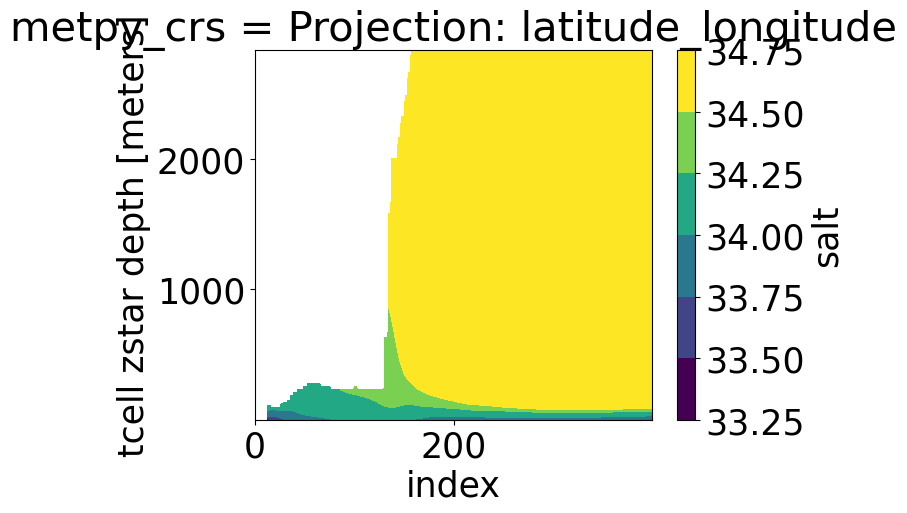

In [22]:
salt_section_wthmp.plot.contourf()

In [73]:
%%time
pot_temp_section_wthp, pot_rho_1_section_wthp, distance_in_km, salt_section_wthp = rho2_temp_cross_section(exp_wthp, shelf_coord, deep_coord, start_time_mw, end_time_mw)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    salt      (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 1min 30s, sys: 2.49 s, total: 1min 32s
Wall time: 1min 32s


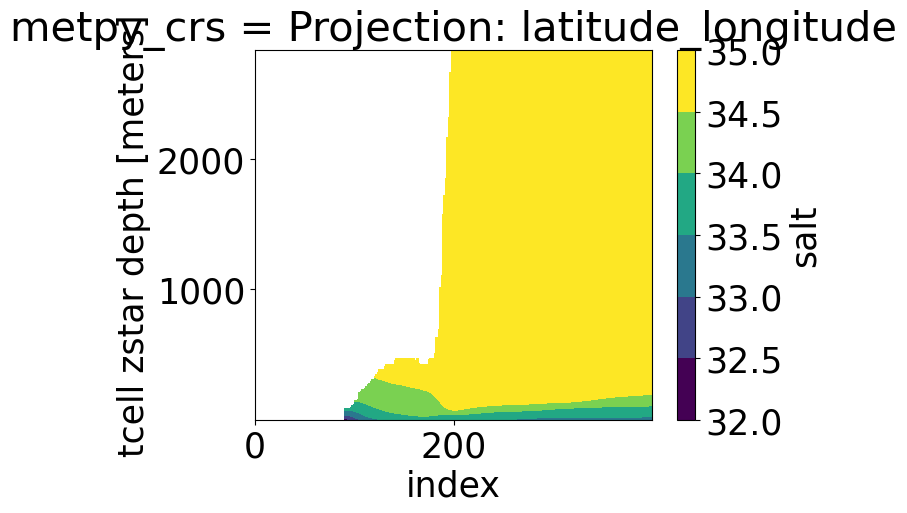

In [74]:
salt_section_wthp.plot.contourf()

In [75]:
%%time
#pot_temp_section_wthmp, pot_rho_1_section_wthmp, distance_in_km = rho2_temp_cross_section(exp_wthmp, shelf_coord, deep_coord, start_time_mw, end_time_mw)
#pot_temp_section_wthp, pot_rho_1_section_wthp, distance_in_km = rho2_temp_cross_section(exp_wthp, shelf_coord, deep_coord, start_time_mw, end_time_mw)
pot_temp_section_ryf, pot_rho_1_section_ryf, distance_in_km, salt_section_ryf = rho2_temp_cross_section(expt, shelf_coord, deep_coord, start_time, end_time)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    salt      (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 19.6 s, sys: 614 ms, total: 20.3 s
Wall time: 20.7 s


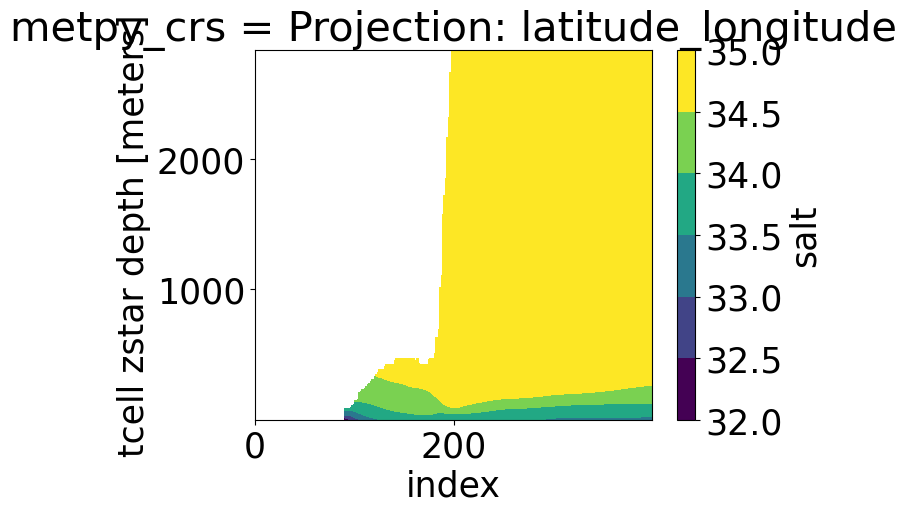

In [76]:
salt_section_ryf.plot.contourf()

## individual plots - can skip

## plotting

In [77]:
import cmocean

In [113]:
pot_rho_1_section_wthp.load()
pot_rho_1_section_wthmp.load()
pot_rho_1_section_ryf.load()

<xarray.DataArray 'pot_rho_1' (st_ocean: 60, index: 400)> Size: 192kB
array([[          nan,           nan,           nan, ..., 1036.25579286,
        1036.25390414, 1036.25200703],
       [          nan,           nan,           nan, ..., 1036.25817909,
        1036.25626873, 1036.2543457 ],
       [          nan,           nan,           nan, ..., 1036.25892235,
        1036.25700443, 1036.25507812],
       ...,
       [          nan,           nan,           nan, ..., 1037.11216347,
        1037.11211953, 1037.11207987],
       [          nan,           nan,           nan, ..., 1037.11815927,
        1037.11810815, 1037.11806132],
       [          nan,           nan,           nan, ..., 1037.12421114,
        1037.12413876, 1037.12406209]])
Coordinates:
  * st_ocean   (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
    metpy_crs  object 8B Projection: latitude_longitude
    x          (index) float64 3kB 3.5 3.49 3.481 3.471 ... 0.5118 0.5059 0.5
    y          (index) float64 3kB -73.0 -72.99 -72.98 ... -68.03 -68.01 -68.0
  * index      (index) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399

Text(0.0, 1.0, 'RYF reference section, shelf (-73.0,-96.5) to (-68.0,-99.5)')

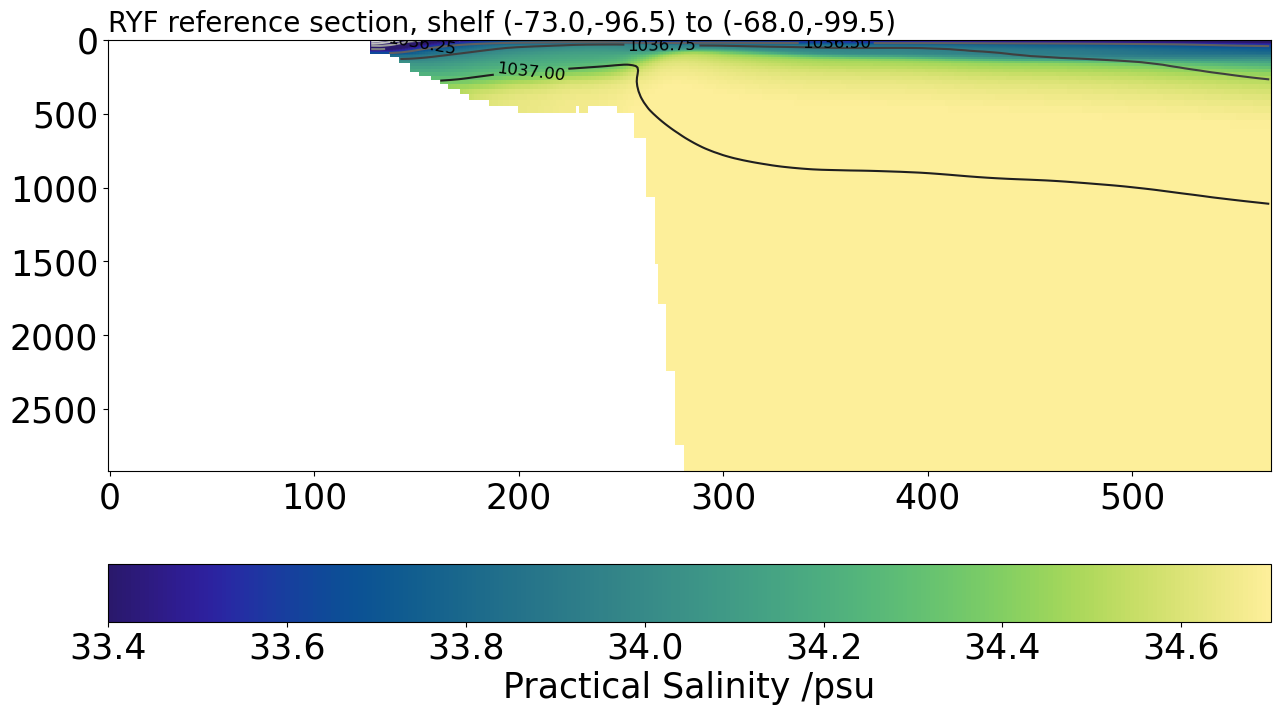

In [81]:
## reference RYF plots SALT
vmax = 34.7
vmin = 33.4

fig, axs = plt.subplots(figsize=(15, 8))

cmesh = axs.pcolormesh(distance_in_km, salt_section_ryf.st_ocean.sel(st_ocean=slice(0,5000)).values, (salt_section_ryf).sel(st_ocean=slice(0,5000)).values, vmax = vmax, vmin = vmin, cmap = cmocean.cm.haline)

cs = axs.contour(distance_in_km[0,:], pot_rho_1_section_ryf.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs.clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'Practical Salinity /psu')
plt.gca().invert_yaxis()
axs.set_title('RYF reference section, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left', fontsize = 20)


In [82]:
pot_temp_section_wthp.load()
pot_temp_section_wthmp.load()
pot_temp_section_ryf.load()

<xarray.DataArray 'pot_temp' (st_ocean: 60, index: 400)> Size: 192kB
array([[         nan,          nan,          nan, ..., 271.67576842,
        271.67699442, 271.67822444],
       [         nan,          nan,          nan, ..., 271.67788487,
        271.6790817 , 271.68028361],
       [         nan,          nan,          nan, ..., 271.67854215,
        271.67972088, 271.68090363],
       ...,
       [         nan,          nan,          nan, ..., 273.77165828,
        273.77243228, 273.77320837],
       [         nan,          nan,          nan, ..., 273.70320158,
        273.70390275, 273.70460816],
       [         nan,          nan,          nan, ..., 273.63722422,
        273.63784003, 273.63845902]])
Coordinates:
  * st_ocean   (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
    metpy_crs  object 8B Projection: latitude_longitude
    x          (index) float64 3kB 3.5 3.49 3.481 3.471 ... 0.5118 0.5059 0.5
    y          (index) float64 3kB -73.0 -72.99 -72.98 ... -68.03 -68.01 -68.0
  * index      (index) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399

Text(0.0, 1.0, 'RYF reference section, shelf (-73.0,-96.5) to (-68.0,-99.5)')

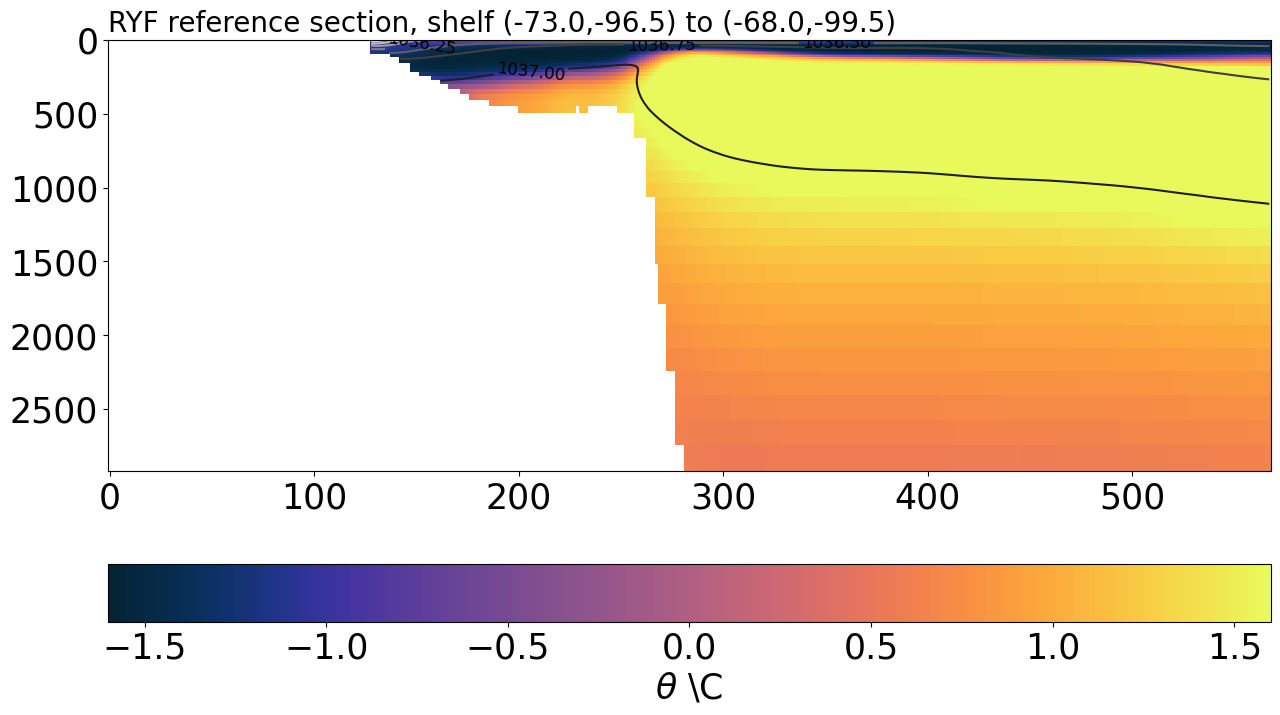

In [83]:
# reference RYF plot TEMP
vmax = 1.6
vmin = -1.6
fig, axs = plt.subplots(figsize=(15, 8))

cmesh = axs.pcolormesh(distance_in_km, pot_temp_section_ryf.st_ocean.sel(st_ocean=slice(0,5000)).values, (pot_temp_section_ryf-273).sel(st_ocean=slice(0,5000)).values,vmax = vmax,vmin = vmin , cmap = cmocean.cm.thermal)

cs = axs.contour(distance_in_km[0,:], pot_rho_1_section_ryf.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs.clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'$\theta$ \C')
plt.gca().invert_yaxis()

axs.set_title('RYF reference section, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left', fontsize = 20)


In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

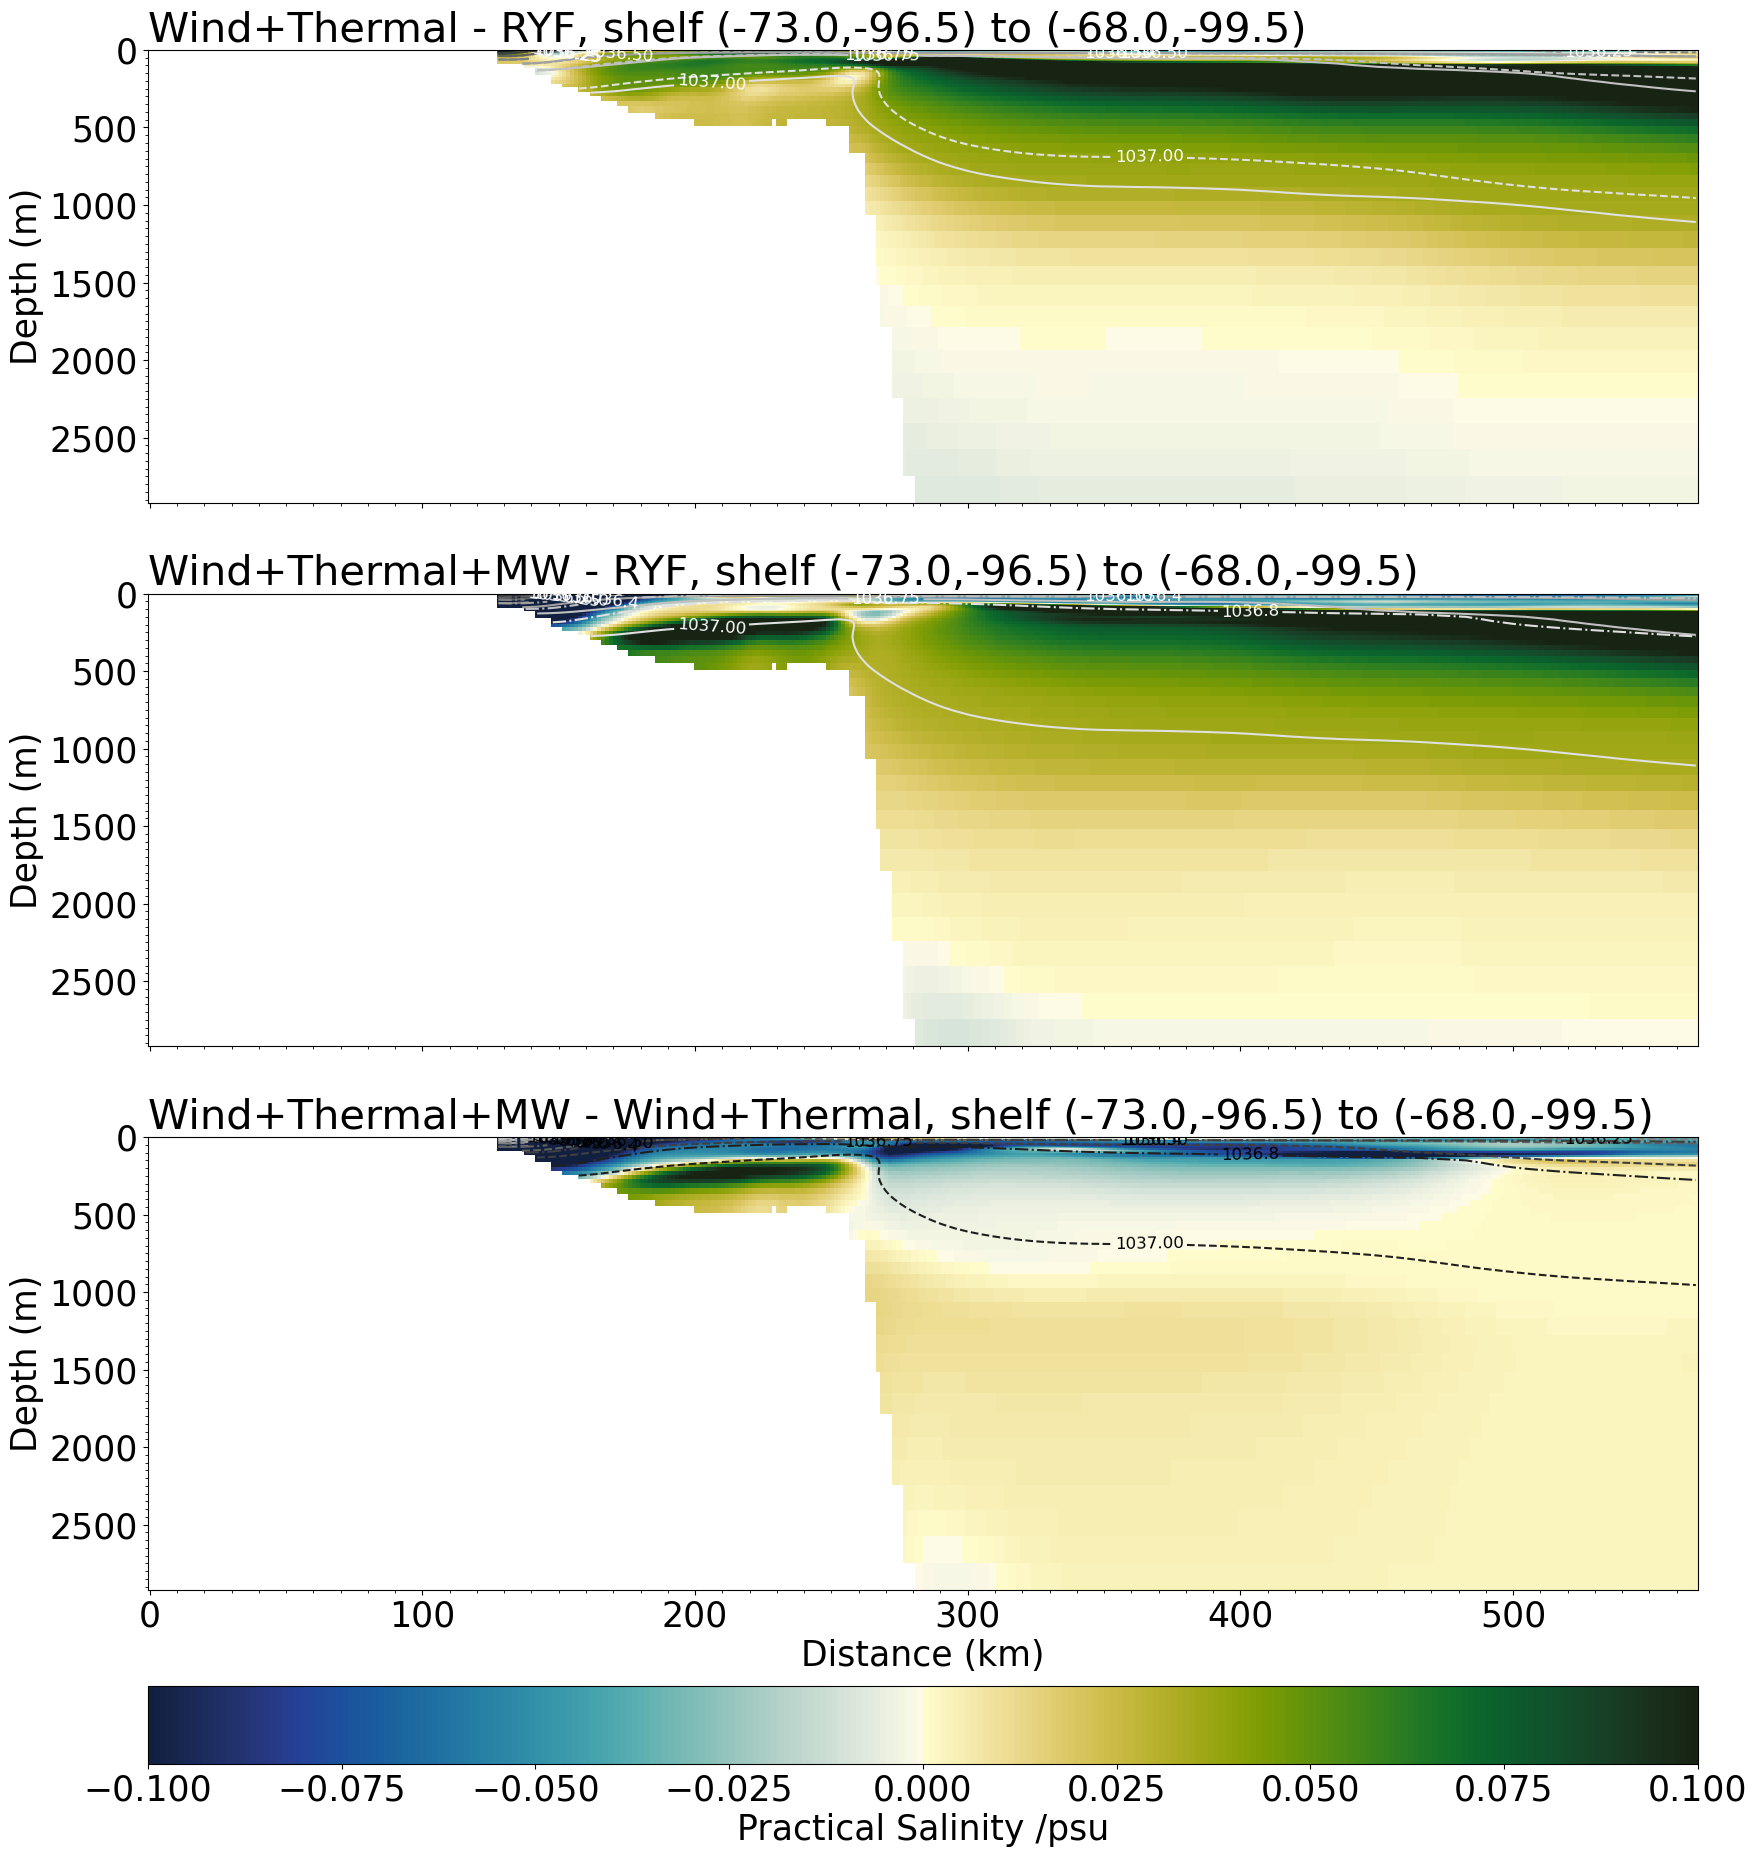

In [84]:
## SALT

vmin=-0.1 #33.6
vmax = 0.1#35
fig, axs = plt.subplots(nrows = 3, figsize=(20, 25), sharex = True)
ft_size = 16

axs[0].set_title('Wind+Thermal - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')

cmesh = axs[0].pcolormesh(distance_in_km, salt_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (salt_section_wthp - salt_section_ryf).sel(st_ocean=slice(0,5000)).values, vmin=vmin, vmax =vmax, cmap = cmocean.cm.delta)

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'w', inline=True,inline_spacing=3)

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'w', inline=True,inline_spacing=3)

# Axes
axs[0].invert_yaxis()
#axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
axs[0].yaxis.set_minor_locator(MultipleLocator(50))


axs[1].set_title('Wind+Thermal+MW - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')
cmesh = axs[1].pcolormesh(distance_in_km, salt_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (salt_section_wthmp - salt_section_ryf).sel(st_ocean=slice(0,5000)).values, vmin=vmin, vmax =vmax,cmap = cmocean.cm.delta)
# Colorbar vmin = 271, vmax = 273,
cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'w', inline=True,inline_spacing=3)

cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'w', inline=True,inline_spacing=3)
# Axes
axs[1].invert_yaxis()
#axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(50))



axs[2].set_title('Wind+Thermal+MW - Wind+Thermal, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), loc='left')
cmesh = axs[2].pcolormesh(distance_in_km, salt_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (salt_section_wthmp - salt_section_wthp).sel(st_ocean=slice(0,5000)).values,vmin=vmin, vmax =vmax,  cmap = cmocean.cm.delta)
cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray_r')
axs[2].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray_r')
axs[2].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)
# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
axs[2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2].yaxis.set_minor_locator(MultipleLocator(50))

cbar = fig.colorbar(cmesh, ax = axs, orientation = 'horizontal', pad = 0.05)
cbar.set_label( r'Practical Salinity /psu')
#cbar.ax.tick_params(labelsize=ft_size)

In [38]:
l 

-2

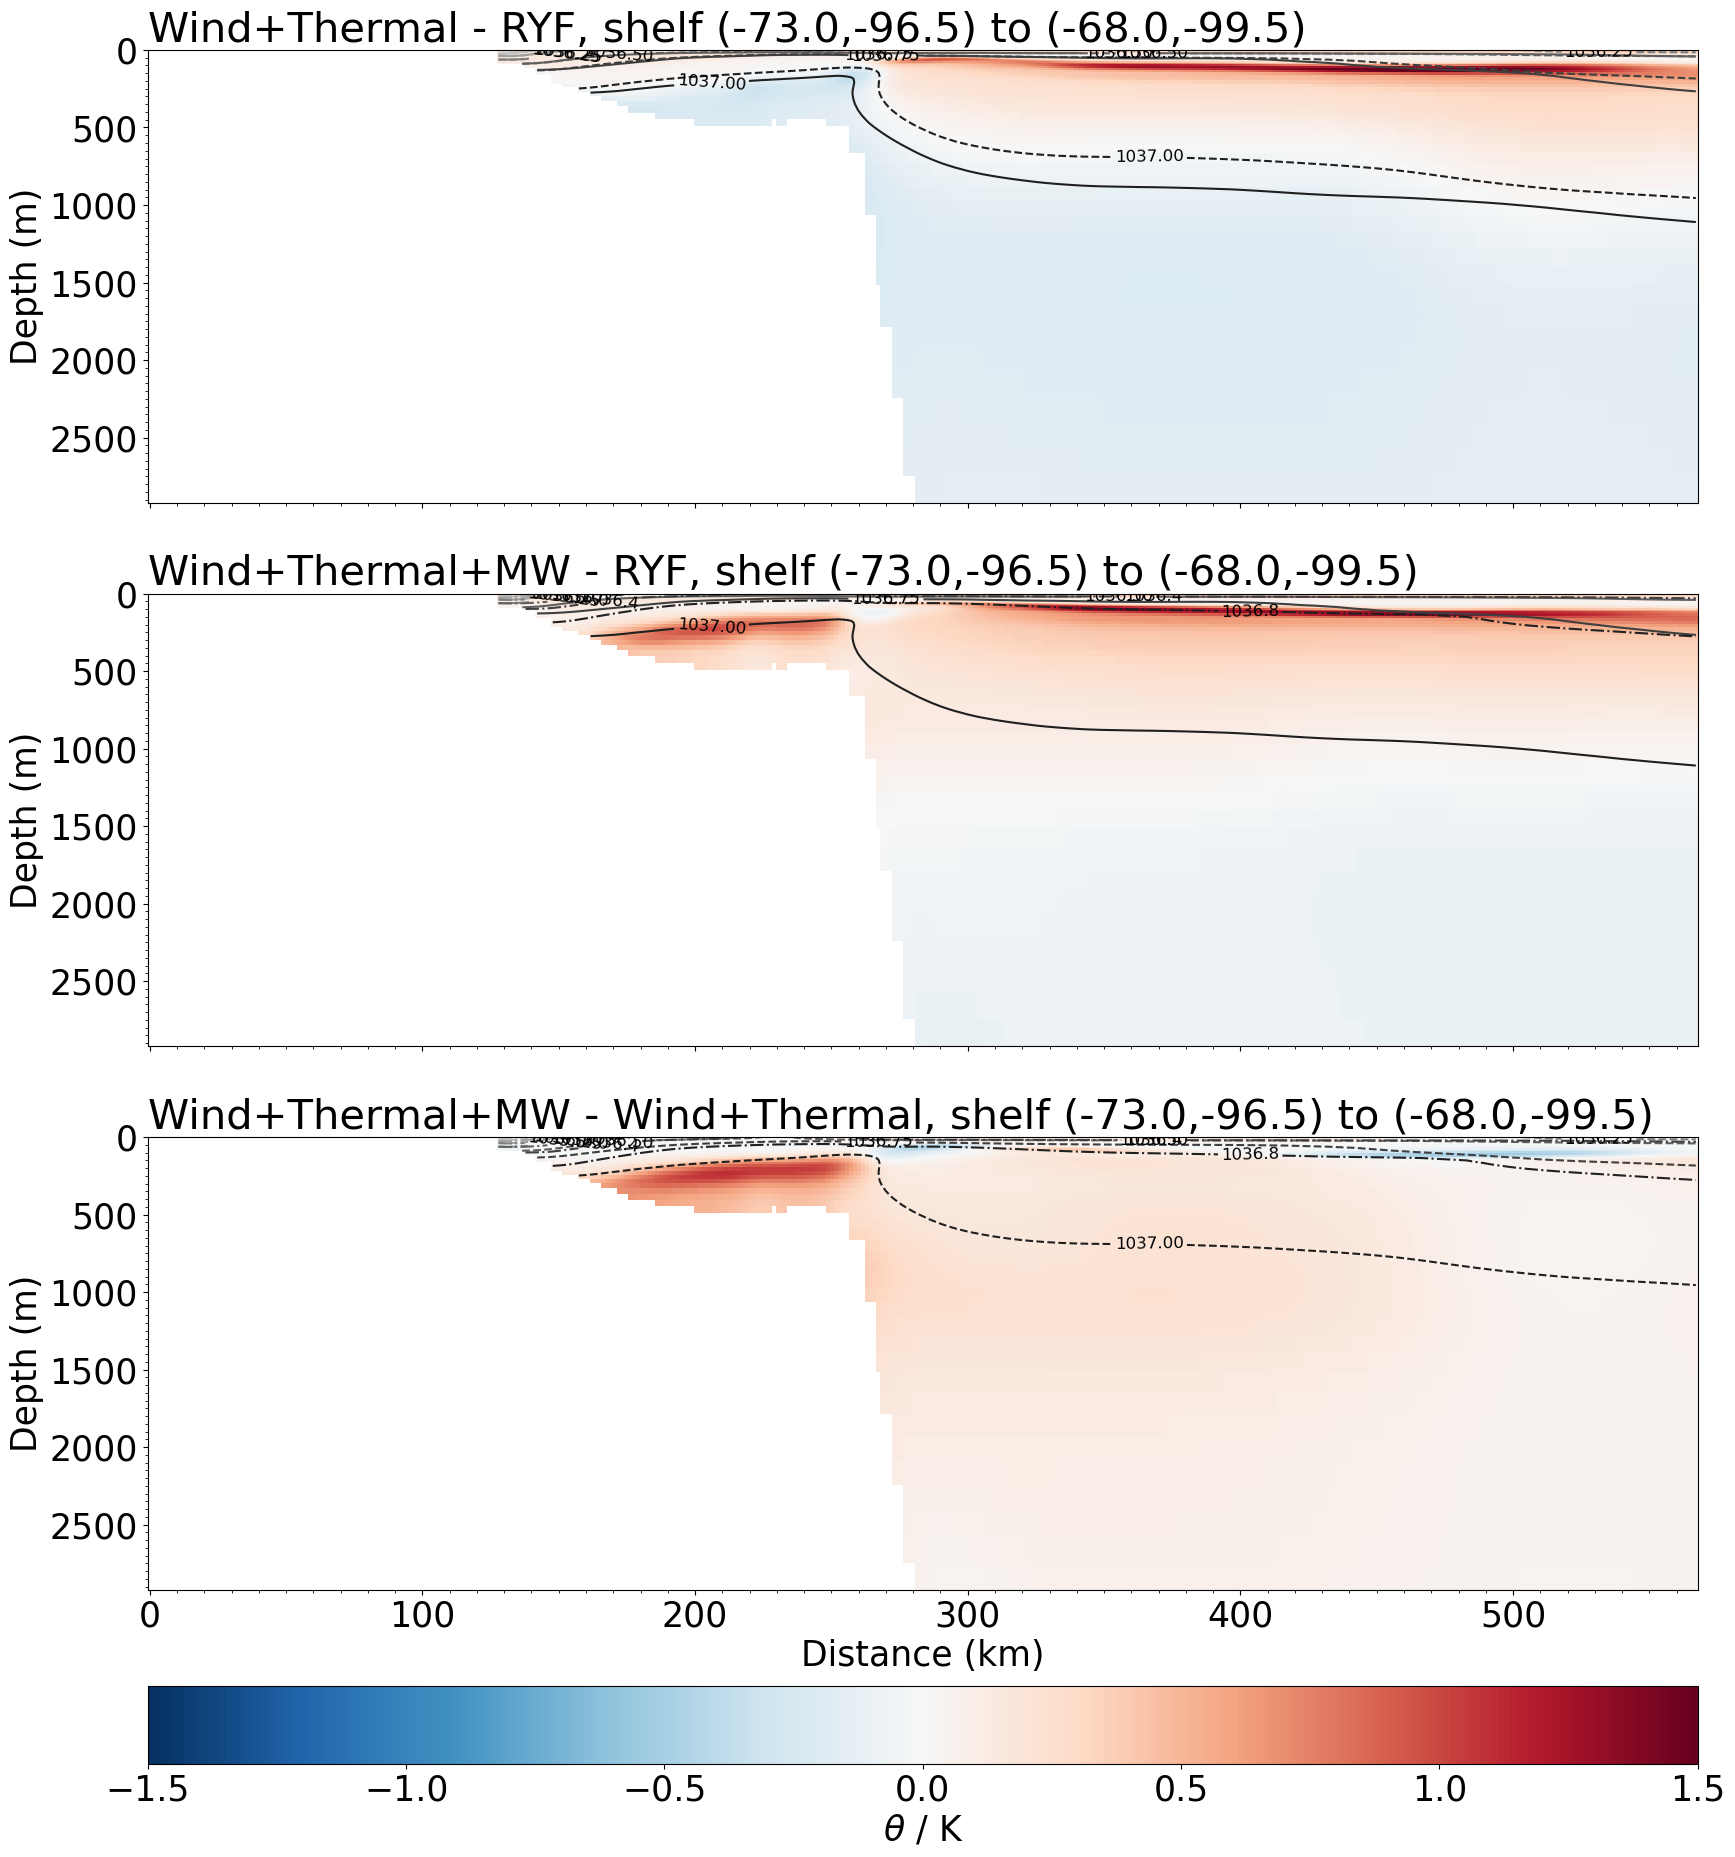

In [85]:
fig, axs = plt.subplots(nrows = 3, figsize=(20, 25), sharex = True)
ft_size = 16

axs[0].set_title('Wind+Thermal - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')

cmesh = axs[0].pcolormesh(distance_in_km, pot_temp_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (pot_temp_section_wthp - pot_temp_section_ryf).sel(st_ocean=slice(0,5000)).values, vmax=1.5 , vmin = -1.5, cmap = 'RdBu_r')

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

# Axes
axs[0].invert_yaxis()
#axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
axs[0].yaxis.set_minor_locator(MultipleLocator(50))


axs[1].set_title('Wind+Thermal+MW - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')
cmesh = axs[1].pcolormesh(distance_in_km, pot_temp_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (pot_temp_section_wthmp - pot_temp_section_ryf).sel(st_ocean=slice(0,5000)).values, vmax=1.5 , vmin = -1.5, cmap = 'RdBu_r')
# Colorbar vmin = 271, vmax = 273,
cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray_r')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)
# Axes
axs[1].invert_yaxis()
#axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(50))



axs[2].set_title('Wind+Thermal+MW - Wind+Thermal, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), loc='left')
cmesh = axs[2].pcolormesh(distance_in_km, pot_temp_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (pot_temp_section_wthmp - pot_temp_section_wthp).sel(st_ocean=slice(0,5000)).values, vmax=1.5 , vmin = -1.5, cmap = 'RdBu_r')
cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray_r')
axs[2].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)
# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
axs[2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2].yaxis.set_minor_locator(MultipleLocator(50))

cbar = fig.colorbar(cmesh, ax = axs, orientation = 'horizontal', pad = 0.05)

#cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'$\theta$ / K')
#cbar.ax.tick_params(labelsize=ft_size)

In [23]:
def age_cross_section(expt, shelf_coord, deep_coord,  start_time, end_time):
    step_no = 400
    pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session,  start_time=start_time, end_time=end_time, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'}) #ncfile="ocean_daily_3d_pot_rho_1.nc"
    

    age =cc.querying.getvar(expt=expt, variable='age_global', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time, end_time=end_time)
    
    pot_rho_2 = pot_rho_2.mean(dim = 'time')#.chunk({'st_ocean': 100})
    pot_rho_2 = pot_rho_2.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
    
    age = age.mean(dim = 'time')#.chunk({'st_ocean': 100})
    age = age.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
   
    pot_rho_2 = grid_depth.interp(grid_depth.interp(pot_rho_2, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
    
    # Create dataset
    ds_pot_rho_1= xr.Dataset({"pot_rho_1": pot_rho_2, "lat": pot_rho_2.yu_ocean, "lon": pot_rho_2.xu_ocean})
    # Interpolate to xu_ocean and yu_ocean
    # Rename coordinate names
    ds_pot_rho_1 = ds_pot_rho_1.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    ds_pot_rho_1['x'] = ds_pot_rho_1['x']+100
    
    ds_pot_rho_1['x'].attrs = pot_rho_2['xu_ocean'].attrs
    
    # MetPy parsing
    pot_rho_1_parsed = ds_pot_rho_1.metpy.parse_cf('pot_rho_1', coordinates={'y': 'y', 'x': 'x'})
    pot_rho_1_section = cross_section(pot_rho_1_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')
   
    age = grid_depth.interp(grid_depth.interp(age, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
    
    # Create dataset
    ds_age= xr.Dataset({"age": age, "lat": age.yu_ocean, "lon": age.xu_ocean})
    # Interpolate to xu_ocean and yu_ocean
    # Rename coordinate names
    print(ds_age)
    ds_age = ds_age.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    # Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
    ds_age['x'] = ds_age['x']+100
    
    ds_age['x'].attrs = age['xu_ocean'].attrs
    
    # MetPy parsing
    age_parsed = ds_age.metpy.parse_cf('age', coordinates={'y': 'y', 'x': 'x'})
    age_section = cross_section(age_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

    # Define number of points you want to interpolate
    step_no = 400
    # Radius of the Earth in km
    r = 6371
    # Difference between points in lat/lon space
    dlon = deep_coord[1]-shelf_coord[1]
    dlat = deep_coord[0]-shelf_coord[0]
    # Calculate distance in km between the two end points
    distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0],deep_coord[0]]))))**2))
    # Create array with length of step_no
    distance_in_km = np.linspace(0, distance_endpoints, step_no)
    # Repeat by the number of depth levels
    distance_in_km = np.tile(distance_in_km, (len(age_section.st_ocean), 1))
        
    return age_section.load(), pot_rho_1_section.load(), distance_in_km

In [24]:
%%time
age_section_wthmp, pot_rho_1_section_wthmp, distance_in_km = age_cross_section(exp_wthmp, shelf_coord, deep_coord, start_time_mw, end_time_mw)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    age       (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 4min 22s, sys: 11.1 s, total: 4min 33s
Wall time: 6min 13s


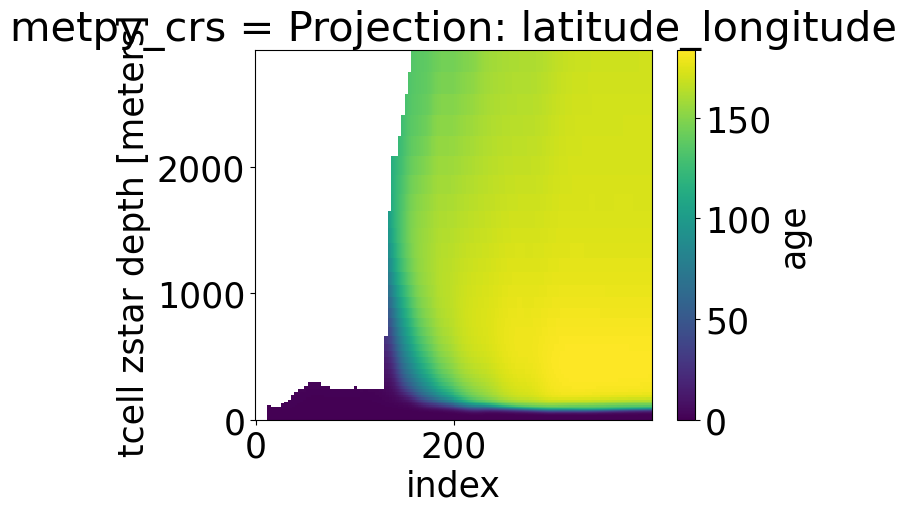

In [25]:
age_section_wthmp.plot()

In [26]:
%%time
age_section_wthp, pot_rho_1_section_wthp, distance_in_km = age_cross_section(exp_wthp, shelf_coord, deep_coord, start_time_mw, end_time_mw)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    age       (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 4min 58s, sys: 11.2 s, total: 5min 9s
Wall time: 6min 2s


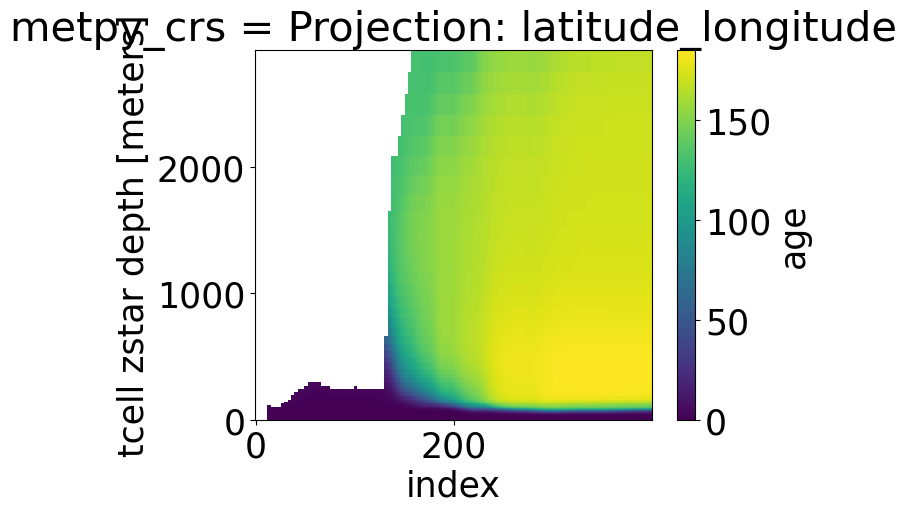

In [27]:
age_section_wthp.plot()

In [28]:
%%time
age_section_ryf, pot_rho_1_section_ryf, distance_in_km = age_cross_section(expt, shelf_coord, deep_coord, start_time_mw, end_time_mw)

<xarray.Dataset> Size: 418MB
Dimensions:   (st_ocean: 60, xu_ocean: 3600, yu_ocean: 484)
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
Data variables:
    age       (st_ocean, yu_ocean, xu_ocean) float32 418MB dask.array<chunksize=(7, 484, 400), meta=np.ndarray>
    lat       (yu_ocean) float64 4kB -79.99 -79.95 -79.9 ... -59.06 -59.01
    lon       (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
CPU times: user 4min 16s, sys: 9.57 s, total: 4min 25s
Wall time: 5min 46s


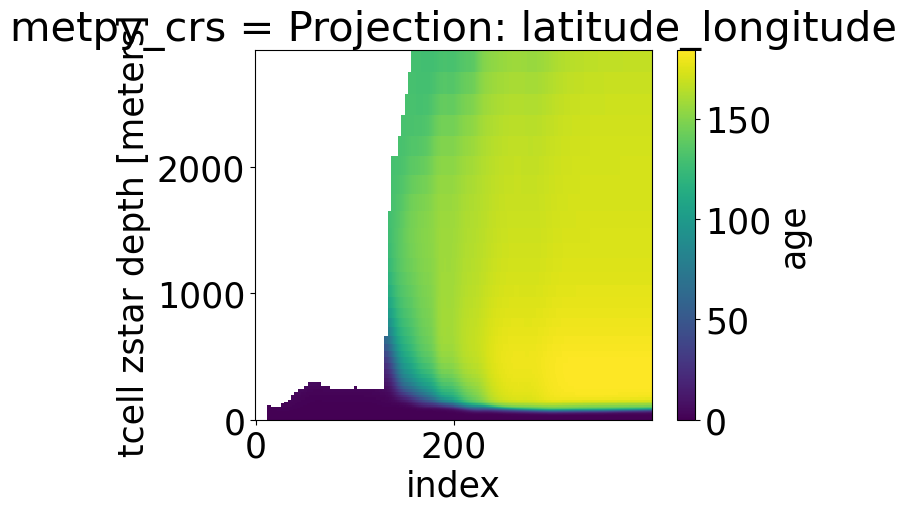

In [29]:
age_section_ryf.plot()

In [31]:
import cmocean

Text(0.0, 1.0, 'RYF reference section, shelf (-70.0,38.5) to (-65.0,38.5)')

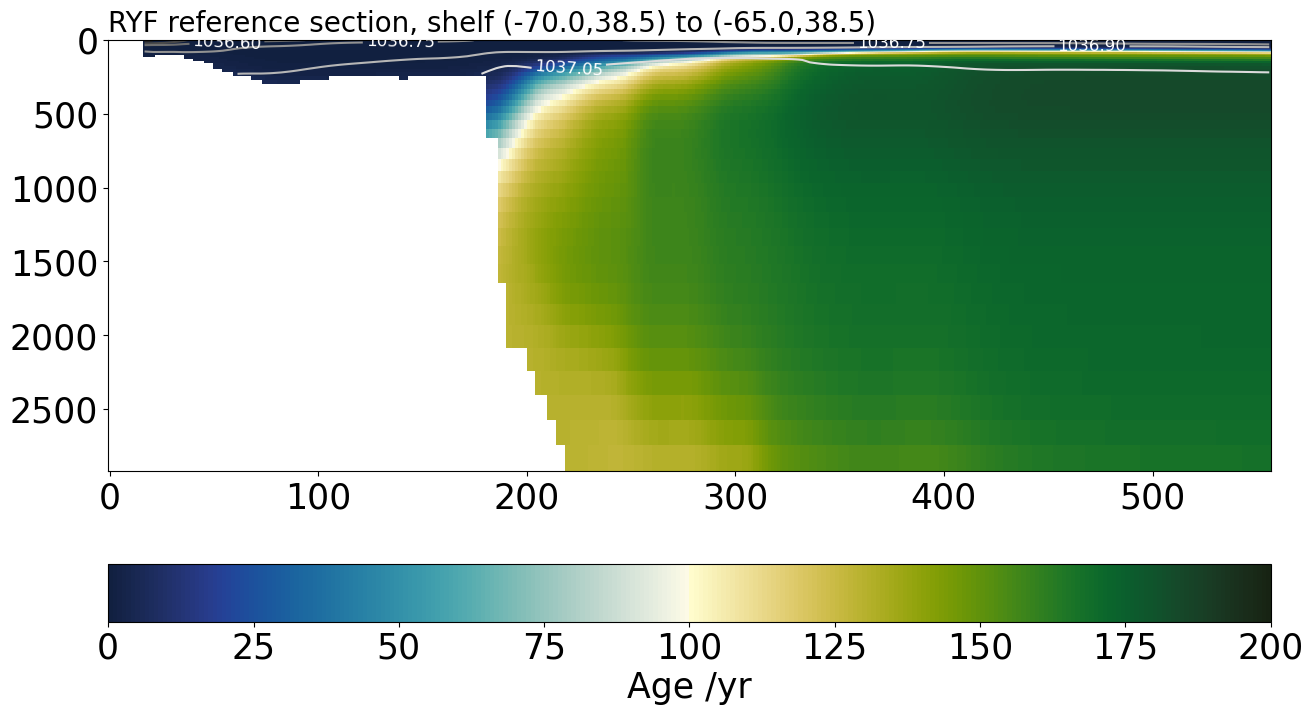

In [32]:
## reference RYF plots SALT
vmax = 200
vmin = 0

fig, axs = plt.subplots(figsize=(15, 8))

cmesh = axs.pcolormesh(distance_in_km, age_section_ryf.st_ocean.sel(st_ocean=slice(0,5000)).values, (age_section_ryf).sel(st_ocean=slice(0,5000)).values, vmax = vmax, vmin = vmin, cmap = cmocean.cm.delta)

cs = axs.contour(distance_in_km[0,:], pot_rho_1_section_ryf.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray')
axs.clabel(cs,cs.levels,fontsize = 12,colors = 'w', inline=True,inline_spacing=3)

cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'Age /yr')
plt.gca().invert_yaxis()
axs.set_title('RYF reference section, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left', fontsize = 20)


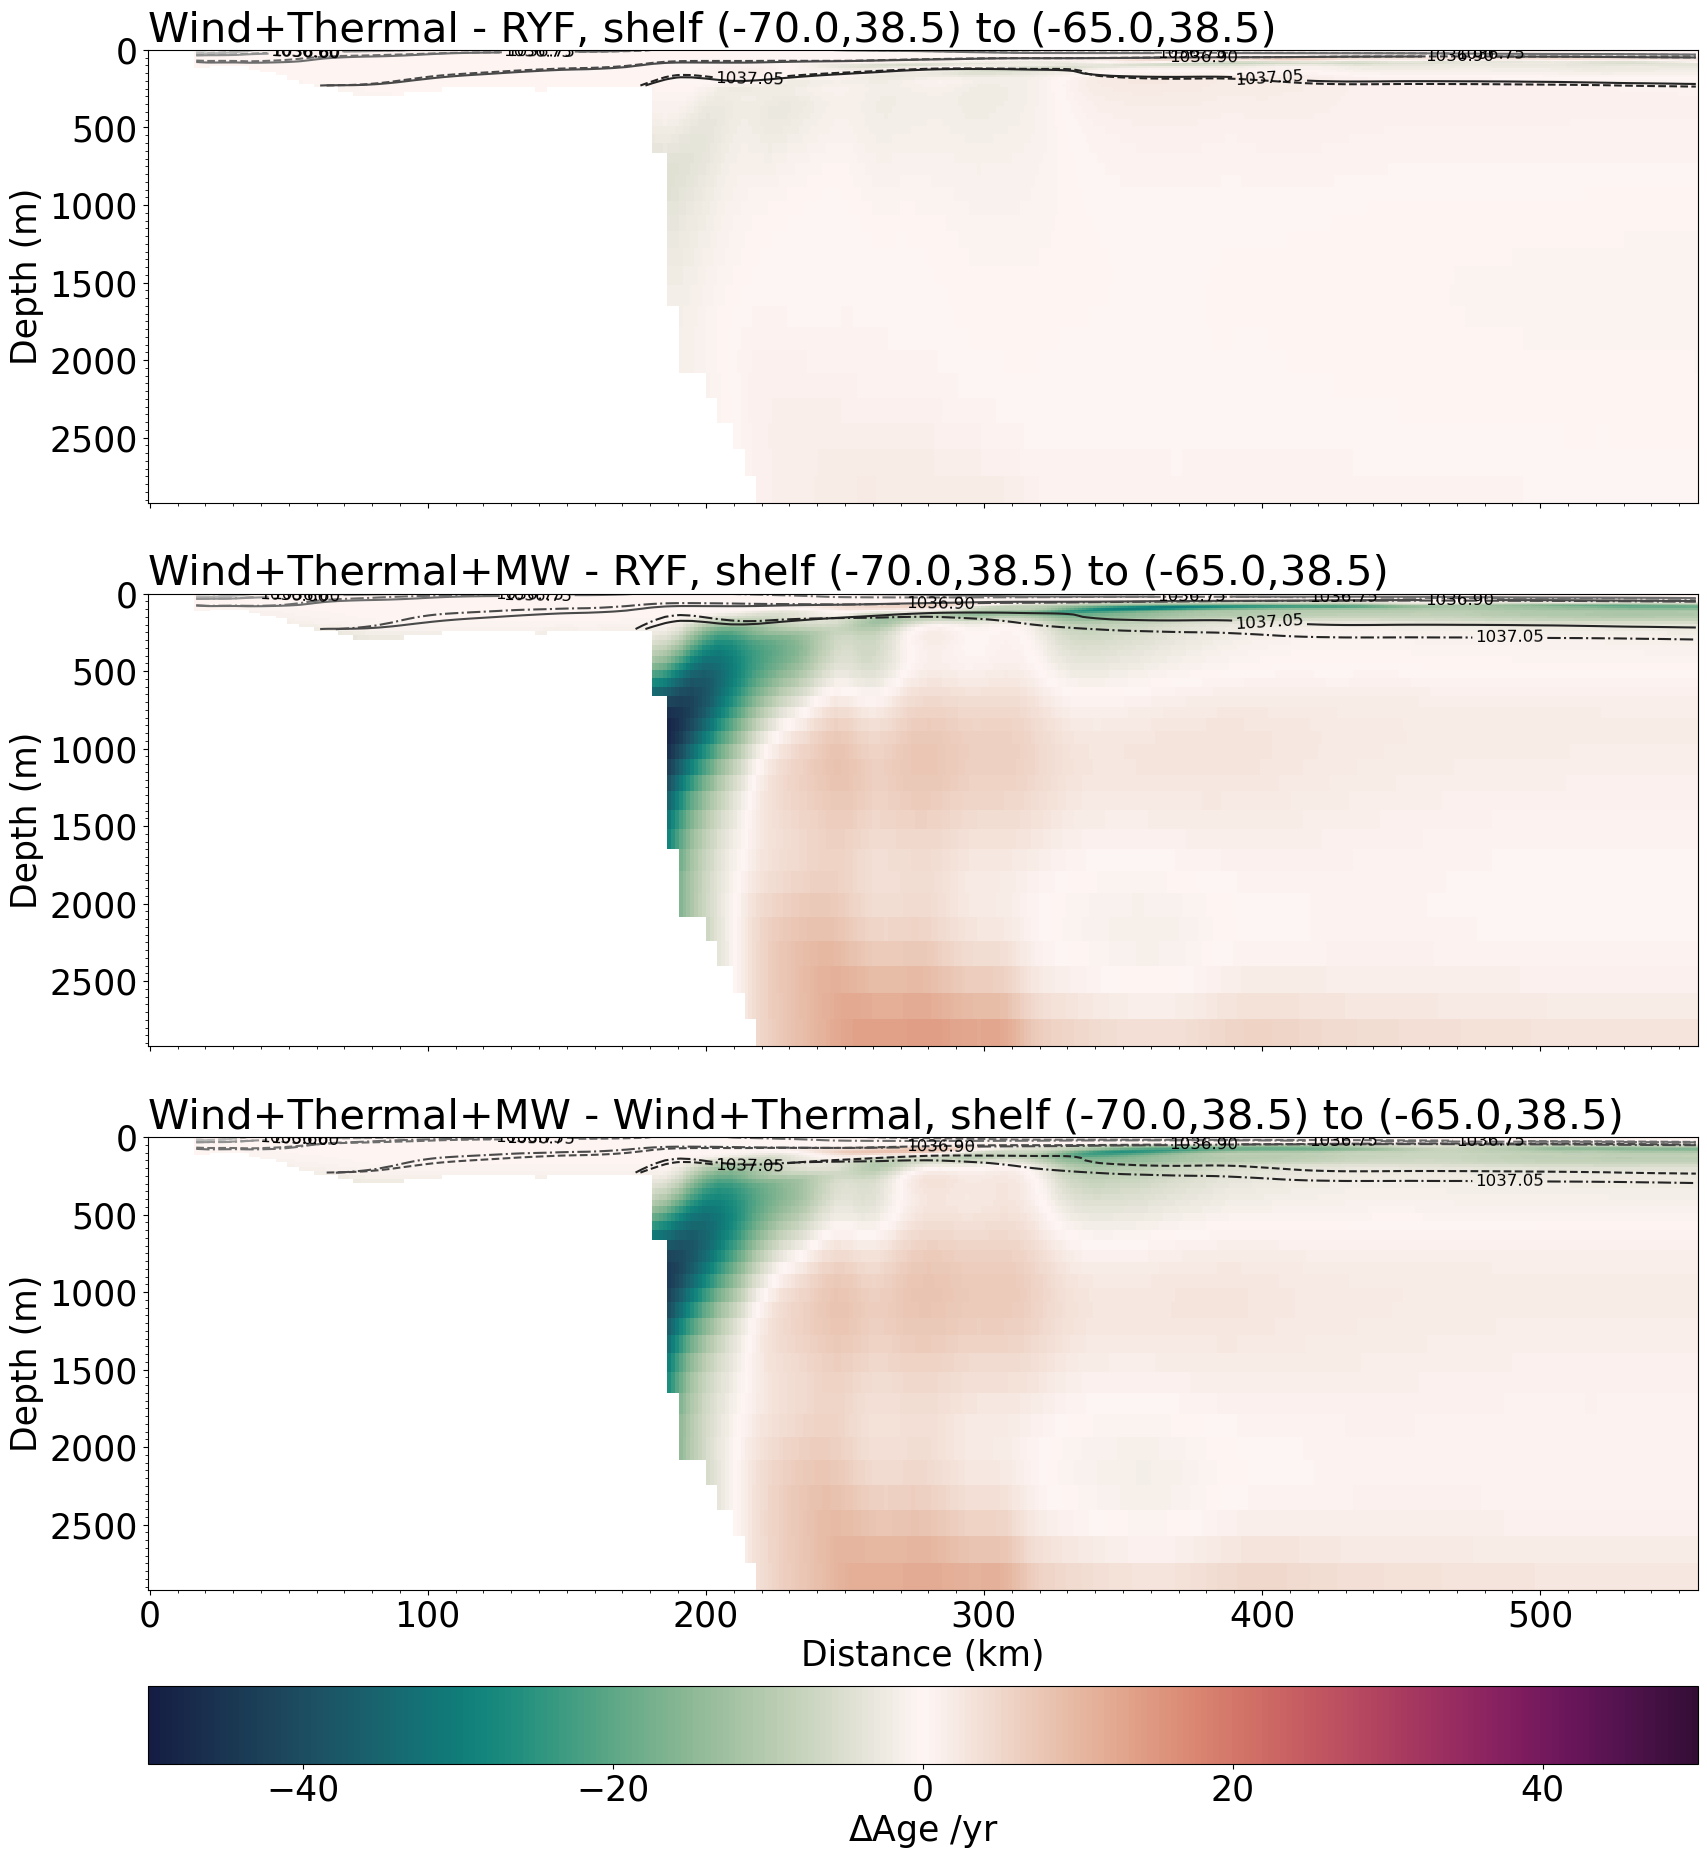

In [33]:
## AGE

vmin=-50 #33.6
vmax = 50#35
fig, axs = plt.subplots(nrows = 3, figsize=(20, 25), sharex = True)
ft_size = 16

axs[0].set_title('Wind+Thermal - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')

cmesh = axs[0].pcolormesh(distance_in_km, age_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (age_section_wthp - age_section_ryf).sel(st_ocean=slice(0,5000)).values, vmin=vmin, vmax =vmax, cmap = cmocean.cm.curl)

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[0].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray_r')
axs[0].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

# Axes
axs[0].invert_yaxis()
#axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
axs[0].yaxis.set_minor_locator(MultipleLocator(50))


axs[1].set_title('Wind+Thermal+MW - RYF, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100),  loc='left')
cmesh = axs[1].pcolormesh(distance_in_km, age_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (age_section_wthmp - age_section_ryf).sel(st_ocean=slice(0,5000)).values, vmin=vmin, vmax =vmax,cmap = cmocean.cm.curl)
# Colorbar vmin = 271, vmax = 273,
cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_ryf), cmap = 'gray_r')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray_r')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)
# Axes
axs[1].invert_yaxis()
#axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(50))



axs[2].set_title('Wind+Thermal+MW - Wind+Thermal, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), loc='left')
cmesh = axs[2].pcolormesh(distance_in_km, age_section_wthmp.st_ocean.sel(st_ocean=slice(0,5000)).values, (age_section_wthmp - age_section_wthp).sel(st_ocean=slice(0,5000)).values,vmin=vmin, vmax =vmax,  cmap = cmocean.cm.curl)
cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthp), linestyles = 'dashed', cmap = 'gray_r')
axs[2].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

cs = axs[2].contour(distance_in_km[0,:], pot_rho_1_section_wthp.st_ocean, (pot_rho_1_section_wthmp), linestyles = 'dashdot', cmap = 'gray_r')
axs[2].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)
# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
axs[2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2].yaxis.set_minor_locator(MultipleLocator(50))

cbar = fig.colorbar(cmesh, ax = axs, orientation = 'horizontal', pad = 0.05)
cbar.set_label( r'$\Delta$Age /yr')
#cbar.ax.tick_params(labelsize=ft_size)

### 
Plotting

In [45]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16

Map of topographic slope and location of cross-slope section

In [46]:
#Pick shelf coordinates
#warm
shelf_coord = (-74, -115+100)
deep_coord  = (-70.5, -115+100)
shelf_coord = (-66.5, -68.5+100)
deep_coord  = (-65, -74+100)
shelf_coord = (-62, -60+100)
deep_coord  = (-56.5, -59+100)

#dense
#shelf_coord = (-67, -58+100)
#deep_coord  = (-67, -52+100)


#hirano shirase glacier
shelf_coord = (-70, 38.5+100)
deep_coord  = (-65, 38.5+100)

shelf_coord = (-67, 53.5+100)
deep_coord  = (-62, 53.5+100)

shelf_coord = (-69, 68.5+100)
deep_coord  = (-64, 68.5+100)

shelf_coord = (-69, 83.5+100)
deep_coord  = (-64, 77.5+100)

shelf_coord = (-68, 128.5 +100)
deep_coord = (-63, 128.5 +100)

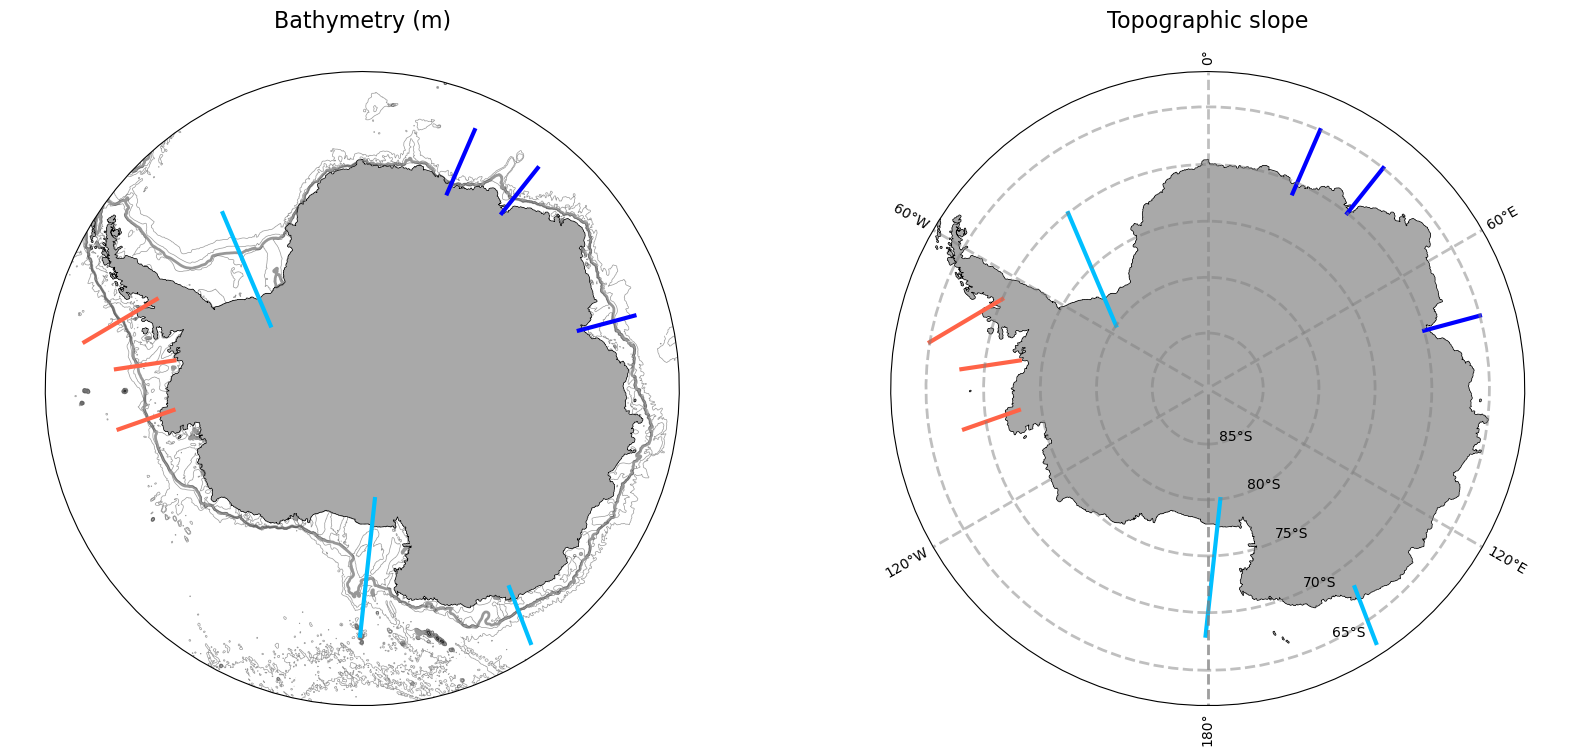

In [50]:
#Plot_coord_list
# Fontsize
ft_size = 16
fig = plt.figure(1, figsize=(20,10))

list_color = ['b','b','b', 'deepskyblue','deepskyblue','deepskyblue','tomato','tomato','tomato']

# LEFT PANEL: bathymetry
ax0 = plt.subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Bathymetry (m)', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
#sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, hu, cmap=cm.cm.deep, transform=ccrs.PlateCarree(), vmin=0, vmax=4000)
# Plot location of cross-slope section (East Antarctica)
for l in np.arange(0,len(plot_coord_list)):
    shelf_coord = plot_coord_list[l][:2]
    deep_coord = plot_coord_list[l][2:]
    plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color=list_color[l], linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
'''
cbar_ax = fig.add_axes([0.48, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
'''

# RIGHT PANEL: topographic slope
ax0 = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Topographic slope', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
#sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, topographic_slope_magnitude, cmap=cm.cm.matter, transform=ccrs.PlateCarree(), vmin=0, vmax=0.1)
# Plot location of cross-slope section (East Antarctica)
for l in np.arange(0,len(plot_coord_list)):
    shelf_coord = plot_coord_list[l][:2]
    deep_coord = plot_coord_list[l][2:]
    plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color=list_color[l], linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
'''
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)
'''
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

#plt.savefig('cross_slope_topography_select.png')


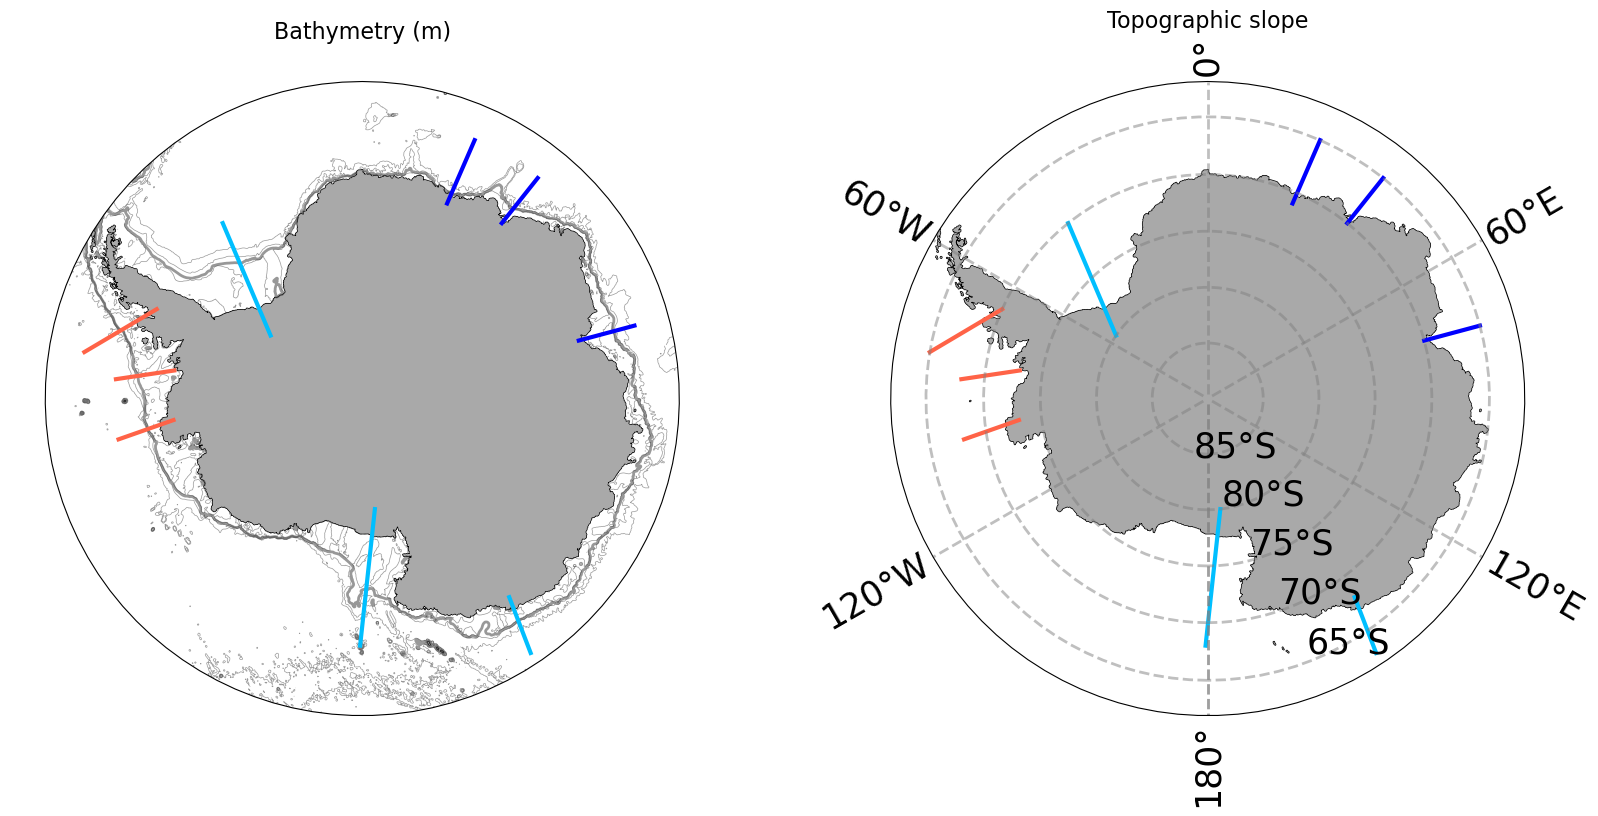

In [89]:
#Plot_coord_list
# Fontsize
ft_size = 16
fig = plt.figure(1, figsize=(20,10))

list_color = ['b','b','b', 'deepskyblue','deepskyblue','deepskyblue','tomato','tomato','tomato']

# LEFT PANEL: bathymetry
ax0 = plt.subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Bathymetry (m)', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
#sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, hu, cmap=cm.cm.deep, transform=ccrs.PlateCarree(), vmin=0, vmax=4000)
# Plot location of cross-slope section (East Antarctica)
for l in np.arange(0,len(plot_coord_list)):
    shelf_coord = plot_coord_list[l][:2]
    deep_coord = plot_coord_list[l][2:]
    plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color=list_color[l], linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
'''
cbar_ax = fig.add_axes([0.48, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
'''

# RIGHT PANEL: topographic slope
ax0 = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Topographic slope', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
#sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, topographic_slope_magnitude, cmap=cm.cm.matter, transform=ccrs.PlateCarree(), vmin=0, vmax=0.1)
# Plot location of cross-slope section (East Antarctica)
for l in np.arange(0,len(plot_coord_list)):
    shelf_coord = plot_coord_list[l][:2]
    deep_coord = plot_coord_list[l][2:]
    plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color=list_color[l], linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
'''
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)
'''
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

#plt.savefig('cross_slope_topography_select.png')
